# Disease Prediction based on symptopms

In [62]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import tarfile
import boto3
from sagemaker import get_execution_role
import sagemaker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

In [63]:
sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()

region = sess.boto_session.region_name

bucket = sess.default_bucket()  # this could also be a hard-coded bucket name

print("Using bucket " + bucket)

Using bucket sagemaker-us-east-1-847397054438


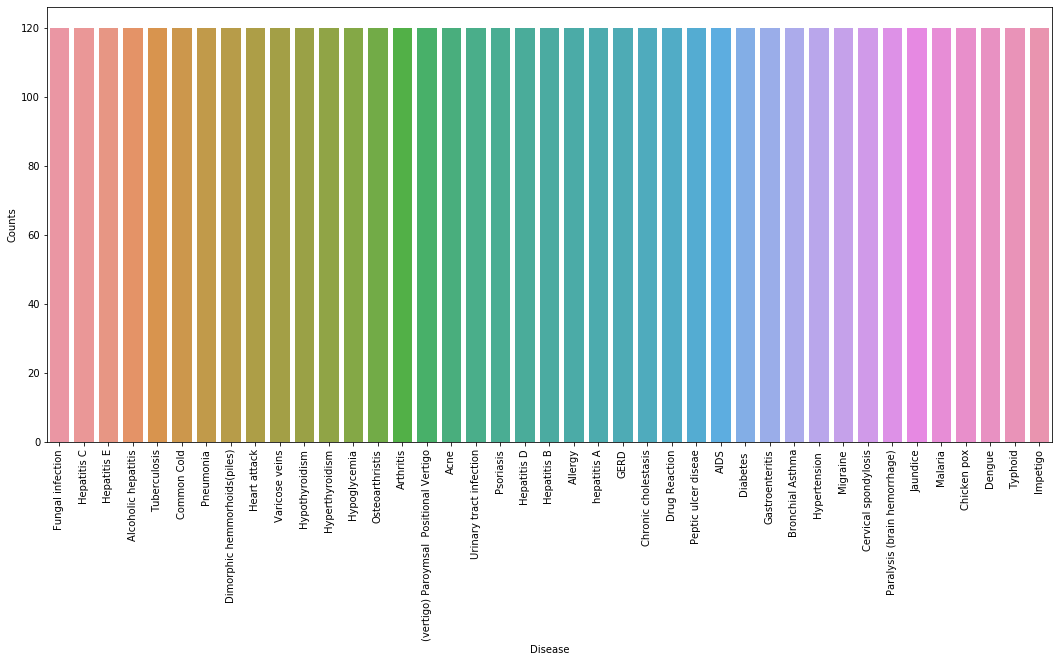

In [64]:
# Reading the train.csv by removing the
# last column since it's an empty column
DATA_PATH = "dataset/Training.csv"
data = pd.read_csv(DATA_PATH).dropna(axis = 1)

# Checking whether the dataset is balanced or not
disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
	"Disease": disease_counts.index,
	"Counts": disease_counts.values
})

plt.figure(figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()

In [65]:
data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [66]:
# Encoding the target value into numerical
# value using LabelEncoder
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

In [67]:
X = data.iloc[:,:-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test =train_test_split(
X, y, test_size = 0.2)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


In [68]:
trainX = pd.DataFrame(X_train, columns=X_train.columns)
trainX["target"] = y_train

testX = pd.DataFrame(X_test, columns=X_test.columns)
testX["target"] = y_test

In [69]:
trainX.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,target
3984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
1913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34
717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39
428,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26


In [70]:
testX.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,target
3926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26
3349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
2745,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,35
555,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28
4207,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36


In [71]:
len(trainX), len(testX)

(3936, 984)

In [72]:
# Make csv of train and test splits
trainX.to_csv("disease_train.csv")
testX.to_csv("disease_test.csv")

In [73]:
# Sending to S3
trainpath = sess.upload_data(
    path="disease_train.csv", bucket=bucket, key_prefix="sagemaker/sklearncontainer"
)

testpath = sess.upload_data(
    path="disease_test.csv", bucket=bucket, key_prefix="sagemaker/sklearncontainer"
)

In [74]:
trainpath

's3://sagemaker-us-east-1-847397054438/sagemaker/sklearncontainer/disease_train.csv'

## Model creation 

### Create script file to run on Sagemaker container

In [84]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="disease_train.csv")
    parser.add_argument("--test-file", type=str, default="disease_test.csv")
    parser.add_argument(
        "--features", type=str
    )  # in this script we ask user to explicitly name features
    parser.add_argument(
        "--target", type=str
    )  # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print("training model")
    model = RandomForestClassifier(random_state = 18)

    model.fit(X_train, y_train)

    # print abs error
    print("validating model")
    abs_err = np.abs(model.predict(X_test) - y_test)
    #print(model.predict(X_test))
    # print couple perf metrics
    for q in [10, 50, 90]:
        print("AE-at-" + str(q) + "th-percentile: " + str(np.percentile(a=abs_err, q=q)))

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)

Overwriting script.py


In [82]:
features = "itching"
for feature in X_train.columns[1:len(X_train.columns)-1]:
    #print(feature)
    features = features + " " + feature
features

'itching skin_rash nodal_skin_eruptions continuous_sneezing shivering chills joint_pain stomach_pain acidity ulcers_on_tongue muscle_wasting vomiting burning_micturition spotting_urination fatigue weight_gain anxiety cold_hands_and_feets mood_swings weight_loss restlessness lethargy patches_in_throat irregular_sugar_level cough high_fever sunken_eyes breathlessness sweating dehydration indigestion headache yellowish_skin dark_urine nausea loss_of_appetite pain_behind_the_eyes back_pain constipation abdominal_pain diarrhoea mild_fever yellow_urine yellowing_of_eyes acute_liver_failure fluid_overload swelling_of_stomach swelled_lymph_nodes malaise blurred_and_distorted_vision phlegm throat_irritation redness_of_eyes sinus_pressure runny_nose congestion chest_pain weakness_in_limbs fast_heart_rate pain_during_bowel_movements pain_in_anal_region bloody_stool irritation_in_anus neck_pain dizziness cramps bruising obesity swollen_legs swollen_blood_vessels puffy_face_and_eyes enlarged_thyroi

In [83]:
! python script.py --n-estimators 100 \
                   --min-samples-leaf 2 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   --features 'itching skin_rash nodal_skin_eruptions continuous_sneezing shivering chills joint_pain stomach_pain acidity ulcers_on_tongue muscle_wasting vomiting burning_micturition spotting_urination fatigue weight_gain anxiety cold_hands_and_feets mood_swings weight_loss restlessness lethargy patches_in_throat irregular_sugar_level cough high_fever sunken_eyes breathlessness sweating dehydration indigestion headache yellowish_skin dark_urine nausea loss_of_appetite pain_behind_the_eyes back_pain constipation abdominal_pain diarrhoea mild_fever yellow_urine yellowing_of_eyes acute_liver_failure fluid_overload swelling_of_stomach swelled_lymph_nodes malaise blurred_and_distorted_vision phlegm throat_irritation redness_of_eyes sinus_pressure runny_nose congestion chest_pain weakness_in_limbs fast_heart_rate pain_during_bowel_movements pain_in_anal_region bloody_stool irritation_in_anus neck_pain dizziness cramps bruising obesity swollen_legs swollen_blood_vessels puffy_face_and_eyes enlarged_thyroid brittle_nails swollen_extremeties excessive_hunger extra_marital_contacts drying_and_tingling_lips slurred_speech knee_pain hip_joint_pain muscle_weakness stiff_neck swelling_joints movement_stiffness spinning_movements loss_of_balance unsteadiness weakness_of_one_body_side loss_of_smell bladder_discomfort foul_smell_of_urine continuous_feel_of_urine passage_of_gases internal_itching toxic_look_(typhos) depression irritability muscle_pain altered_sensorium red_spots_over_body belly_pain abnormal_menstruation dischromic_patches watering_from_eyes increased_appetite polyuria family_history mucoid_sputum rusty_sputum lack_of_concentration visual_disturbances receiving_blood_transfusion receiving_unsterile_injections coma stomach_bleeding distention_of_abdomen history_of_alcohol_consumption fluid_overload.1 blood_in_sputum prominent_veins_on_calf palpitations painful_walking pus_filled_pimples blackheads scurring skin_peeling silver_like_dusting small_dents_in_nails inflammatory_nails blister red_sore_around_nose yellow_crust_ooze'\
                   --target target

extracting arguments
reading data
building training and testing datasets
training model
validating model
[26 13 35 28 36 17 21 36  6 12 22 10 29 13 31 12  5  0 34 28 23 32 16 37
 19 14 30 30 37 19  0 30 11 17 18  5 27 33  2  9 15 25 31  1  5  5 12 31
 21  2 17 15 10  8 21 26  0  9 35 12 15 32  5 29 27 13  5  7 21 30 14 30
  9 24  5 35  3 37 39 36 16 19 15 18  5 31 26 26 37 31 25  5 16 39 24 26
  9  6 35 30 37 28 36 30 19 29 22 25 24 33 32 14 37  4 16 14 26 31 32 10
 16 26 19  2 32 27 35  4  8 14 13 27  9 37 10 29  7 20 39 18 37 11 37 20
 21 19  9 20 37 22 31 38 13 15  5 34  4  1  4 30 23 10 12 15 17 17 17 22
 27 32 36 13 24 25 35 13 29 12 19 11  2 35  0 30 26  2 15 35 35 21  8 20
 33 18  4 26 31 37 30 10  8 13 28 28  8 37  3 14 23 17 39 32 40 39  0 24
 17 17 36 27 37 23 12 40 31 32 33 17 40  8 23 37 18 19  4 30 24 28  2 11
  2  9 30  7 10  0 10 26 30 28 19  1 38 28 21  0 36 14 17 28 15 14  4 35
 10 21 26 26 12 23  3  3  2 24 19 25  9  2 39  1 29 31 11 24 25 38 18 36
 35  9 18 13 31  7 

In [86]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
        "features": features,
        "target": "target"
    },
)

In [87]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=False)

In [206]:
# first compress the code and send to S3

source = "source.tar.gz"
project = "scikitlearn-train-from-boto3"

tar = tarfile.open(source, "w:gz")
tar.add("script.py")
tar.close()

s3 = boto3.client("s3")
s3.upload_file(source, bucket, project + "/" + source)

In [89]:
from sagemaker import image_uris


training_image = image_uris.retrieve(
    framework="sklearn",
    region=region,
    version=FRAMEWORK_VERSION,
    py_version="py3",
    instance_type="ml.c5.xlarge",
)
print(training_image)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3


In [90]:
# launch training job

response = sm_boto3.create_training_job(
    TrainingJobName="sklearn-boto3-" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"),
    HyperParameters={
        "n_estimators": "300",
        "min_samples_leaf": "3",
        "sagemaker_program": "script.py",
        "features": features,
        "target": "target",
        "sagemaker_submit_directory": "s3://" + bucket + "/" + project + "/" + source,
    },
    AlgorithmSpecification={
        "TrainingImage": training_image,
        "TrainingInputMode": "File",
        "MetricDefinitions": [
            {"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"},
        ],
    },
    RoleArn=get_execution_role(),
    InputDataConfig=[
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": trainpath,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
        },
        {
            "ChannelName": "test",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": testpath,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
        },
    ],
    OutputDataConfig={"S3OutputPath": "s3://" + bucket + "/sagemaker-sklearn-artifact/"},
    ResourceConfig={"InstanceType": "ml.c5.xlarge", "InstanceCount": 1, "VolumeSizeInGB": 10},
    StoppingCondition={"MaxRuntimeInSeconds": 86400},
    EnableNetworkIsolation=False,
)

print(response)

{'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:847397054438:training-job/sklearn-boto3-2022-07-30-11-24-38', 'ResponseMetadata': {'RequestId': 'add5ea14-f0dc-4279-a43c-d31585139799', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'add5ea14-f0dc-4279-a43c-d31585139799', 'content-type': 'application/x-amz-json-1.1', 'content-length': '108', 'date': 'Sat, 30 Jul 2022 11:24:37 GMT'}, 'RetryAttempts': 0}}


In [91]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)


2022-07-30 11:25:38 Starting - Preparing the instances for training
2022-07-30 11:25:38 Downloading - Downloading input data
2022-07-30 11:25:38 Training - Training image download completed. Training in progress.
2022-07-30 11:25:38 Uploading - Uploading generated training model
2022-07-30 11:25:38 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-847397054438/rf-scikit-2022-07-30-11-21-13-844/output/model.tar.gz


In [92]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [93]:
predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)

-----!

In [95]:
# the SKLearnPredictor does the serialization from pandas for us
print(predictor.predict(testX[features.split(" ")]))

[26 13 35 28 36 17 21 36  6 12 22 10 29 13 31 12  5  0 34 28 23 32 16 37
 19 14 30 30 37 19  0 30 11 17 18  5 27 33  2  9 15 25 31  1  5  5 12 31
 21  2 17 15 10  8 21 26  0  9 35 12 15 32  5 29 27 13  5  7 21 30 14 30
  9 24  5 35  3 37 39 36 16 19 15 18  5 31 26 26 37 31 25  5 16 39 24 26
  9  6 35 30 37 28 36 30 19 29 22 25 24 33 32 14 37  4 16 14 26 31 32 10
 16 26 19  2 32 27 35  4  8 14 13 27  9 37 10 29  7 20 39 18 37 11 37 20
 21 19  9 20 37 22 31 38 13 15  5 34  4  1  4 30 23 10 12 15 17 17 17 22
 27 32 36 13 24 25 35 13 29 12 19 11  2 35  0 30 26  2 15 35 35 21  8 20
 33 18  4 26 31 37 30 10  8 13 28 28  8 37  3 14 23 17 39 32 40 39  0 24
 17 17 36 27 37 23 12 40 31 32 33 17 40  8 23 37 18 19  4 30 24 28  2 11
  2  9 30  7 10  0 10 26 30 28 19  1 38 28 21  0 36 14 17 28 15 14  4 35
 10 21 26 26 12 23  3  3  2 24 19 25  9  2 39  1 29 31 11 24 25 38 18 36
 35  9 18 13 31  7 23 29 35 18 11 12 23  4 38 31 34 25 12  1 29 23 25 38
 36 40 22 30 31 29 29  4 25 17 32 31 24 29 12 19 10

In [96]:
runtime = boto3.client("sagemaker-runtime")

In [177]:
# csv serialization
#testX[features.split(" ")].to_csv("check2.csv")
response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint,
    Body=testX[features.split(" ")].to_csv(header=False, index=False).encode("utf-8"),
    ContentType="text/csv",
)

print(response["Body"].read())

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


b'[26, 13, 35, 28, 36, 17, 21, 36, 6, 12, 22, 10, 29, 13, 31, 12, 5, 0, 34, 28, 23, 32, 16, 37, 19, 14, 30, 30, 37, 19, 0, 30, 11, 17, 18, 5, 27, 33, 2, 9, 15, 25, 31, 1, 5, 5, 12, 31, 21, 2, 17, 15, 10, 8, 21, 26, 0, 9, 35, 12, 15, 32, 5, 29, 27, 13, 5, 7, 21, 30, 14, 30, 9, 24, 5, 35, 3, 37, 39, 36, 16, 19, 15, 18, 5, 31, 26, 26, 37, 31, 25, 5, 16, 39, 24, 26, 9, 6, 35, 30, 37, 28, 36, 30, 19, 29, 22, 25, 24, 33, 32, 14, 37, 4, 16, 14, 26, 31, 32, 10, 16, 26, 19, 2, 32, 27, 35, 4, 8, 14, 13, 27, 9, 37, 10, 29, 7, 20, 39, 18, 37, 11, 37, 20, 21, 19, 9, 20, 37, 22, 31, 38, 13, 15, 5, 34, 4, 1, 4, 30, 23, 10, 12, 15, 17, 17, 17, 22, 27, 32, 36, 13, 24, 25, 35, 13, 29, 12, 19, 11, 2, 35, 0, 30, 26, 2, 15, 35, 35, 21, 8, 20, 33, 18, 4, 26, 31, 37, 30, 10, 8, 13, 28, 28, 8, 37, 3, 14, 23, 17, 39, 32, 40, 39, 0, 24, 17, 17, 36, 27, 37, 23, 12, 40, 31, 32, 33, 17, 40, 8, 23, 37, 18, 19, 4, 30, 24, 28, 2, 11, 2, 9, 30, 7, 10, 0, 10, 26, 30, 28, 19, 1, 38, 28, 21, 0, 36, 14, 17, 28, 15, 14, 4,

## Testing for real user input

In [101]:
symptoms = data.columns.values[:-1]

In [123]:
testX.columns[:-1]

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling',
       'silver_like_dusting', 'small_dents_in_nails', 'inflammatory_nails',
       'blister', 'red_sore_around_nose', 'yellow_crust_ooze'],
      dtype='object', length=132)

In [138]:
input_data = "itching,skin_rash,nodal_skin_eruptions".lower().split(",")
input_data

['itching', 'skin_rash', 'nodal_skin_eruptions']

In [139]:
diseasemap = {}
for i in symptoms:
    if i in input_data:
        diseasemap[i] = 1
    else:
        diseasemap[i] = 0
diseasemap

{'itching': 1,
 'skin_rash': 1,
 'nodal_skin_eruptions': 1,
 'continuous_sneezing': 0,
 'shivering': 0,
 'chills': 0,
 'joint_pain': 0,
 'stomach_pain': 0,
 'acidity': 0,
 'ulcers_on_tongue': 0,
 'muscle_wasting': 0,
 'vomiting': 0,
 'burning_micturition': 0,
 'spotting_urination': 0,
 'fatigue': 0,
 'weight_gain': 0,
 'anxiety': 0,
 'cold_hands_and_feets': 0,
 'mood_swings': 0,
 'weight_loss': 0,
 'restlessness': 0,
 'lethargy': 0,
 'patches_in_throat': 0,
 'irregular_sugar_level': 0,
 'cough': 0,
 'high_fever': 0,
 'sunken_eyes': 0,
 'breathlessness': 0,
 'sweating': 0,
 'dehydration': 0,
 'indigestion': 0,
 'headache': 0,
 'yellowish_skin': 0,
 'dark_urine': 0,
 'nausea': 0,
 'loss_of_appetite': 0,
 'pain_behind_the_eyes': 0,
 'back_pain': 0,
 'constipation': 0,
 'abdominal_pain': 0,
 'diarrhoea': 0,
 'mild_fever': 0,
 'yellow_urine': 0,
 'yellowing_of_eyes': 0,
 'acute_liver_failure': 0,
 'fluid_overload': 0,
 'swelling_of_stomach': 0,
 'swelled_lymph_nodes': 0,
 'malaise': 0,
 'bl

In [141]:
evaluation_data = pd.DataFrame(diseasemap, index = [0])
evaluation_data

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
X_test

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,target
3926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26
3349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
2745,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,35
555,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28
4207,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34
563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
860,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,14
1225,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,27


In [203]:
# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
	symptom = " ".join([i.capitalize() for i in value.split("_")])
	symptom_index[symptom] = index

data_dict = {
	"symptom_index":symptom_index,
	"predictions_classes":encoder.classes_
}
print(data_dict)
# Defining the Function
# Input: string containing symptoms separated by commmas
# Output: Generated predictions by models
inp_data = "Chills,Fatigue,Cough,Breathlessness,High Fever,Chest Pain,Rusty Sputum".split(",")
# creating input data for the models
input_data = [0] * len(data_dict["symptom_index"])
for symptomg in inp_data:
    index = data_dict["symptom_index"][symptomg]
    input_data[index] = 1
# reshaping the input data and converting it
# into suitable format for model predictions
input_data = np.array(input_data).reshape(1,-1)
print(input_data)
# making a dataframe of numpy array
send_values = pd.DataFrame(input_data, columns = symptoms)
old_df = testX[features.split(" ")]
send_values = send_values.append(old_df)
#send_values[features.split(" ")].to_csv("check.csv", index = False)
#send_values = pd.read_csv("check.csv")
# getting prediction from model
response = runtime.invoke_endpoint(EndpointName=predictor.endpoint, Body=send_values.to_csv(header=False, index=False).encode("utf-8"), ContentType="text/csv")
import re
# making final prediction by taking mode of all predictions
#prediction
JJ = response["Body"].read()

resp_nums = [int(s) for s in re.findall(r'\b\d+\b', JJ.decode("UTF-8"))]

predictions = data_dict["predictions_classes"][resp_nums[0]]
#predictions = data_dict["predictions_classes"][JJ[0]]
predictions
# Testing the function
#print(predictDisease("Itching,Skin Rash,Nodal Skin Eruptions", runtime))


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'symptom_index': {'Itching': 0, 'Skin Rash': 1, 'Nodal Skin Eruptions': 2, 'Continuous Sneezing': 3, 'Shivering': 4, 'Chills': 5, 'Joint Pain': 6, 'Stomach Pain': 7, 'Acidity': 8, 'Ulcers On Tongue': 9, 'Muscle Wasting': 10, 'Vomiting': 11, 'Burning Micturition': 12, 'Spotting Urination': 13, 'Fatigue': 14, 'Weight Gain': 15, 'Anxiety': 16, 'Cold Hands And Feets': 17, 'Mood Swings': 18, 'Weight Loss': 19, 'Restlessness': 20, 'Lethargy': 21, 'Patches In Throat': 22, 'Irregular Sugar Level': 23, 'Cough': 24, 'High Fever': 25, 'Sunken Eyes': 26, 'Breathlessness': 27, 'Sweating': 28, 'Dehydration': 29, 'Indigestion': 30, 'Headache': 31, 'Yellowish Skin': 32, 'Dark Urine': 33, 'Nausea': 34, 'Loss Of Appetite': 35, 'Pain Behind The Eyes': 36, 'Back Pain': 37, 'Constipation': 38, 'Abdominal Pain': 39, 'Diarrhoea': 40, 'Mild Fever': 41, 'Yellow Urine': 42, 'Yellowing Of Eyes': 43, 'Acute Liver Failure': 44, 'Fluid Overload': 45, 'Swelling Of Stomach': 46, 'Swelled Lymph Nodes': 47, 'Malaise':

'Pneumonia'

In [204]:
with open(r'symptoms.txt', 'w') as fp:
    for item in symptoms:
        # write each item on a new line
        fp.write("%s\n" % item)

In [205]:
with open(r'features.txt', 'w') as fp:
    for item in features:
        # write each item on a new line
        fp.write("%s\n" % item)